In [1]:
!pip install scikit-learn

In [2]:
pip install tensorly tensorly-torch

Note: you may need to restart the kernel to use updated packages.


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_squared_error, f1_score, precision_score, recall_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM
import random
from sklearn.preprocessing import OneHotEncoder as Encoder
from tltorch import TRL
from collections import OrderedDict

In [ ]:
class Bilinear(nn.Module):
    """
    Bilinear layer introduces pairwise product to a NN to model possible combinatorial effects.
    This particular implementation attempts to leverage the number of parameters via low-rank tensor decompositions.

    Parameters
    ----------
    n : int
        Number of input features.
    out : int, optional
        Number of output features. If None, assumed to be equal to the number of input features. The default is None.
    rank : float, optional
        Fraction of maximal to rank to be used in tensor decomposition. The default is 0.05.
    bias : bool, optional
        If True, bias is used. The default is False.

    """
    def __init__(self, n: int, out=None, rank=0.05, bias=False):
        super().__init__()
        if out is None:
            out = (n, )
        self.trl = TRL((n, n), out, bias=bias, rank=rank)
        self.trl.weight = self.trl.weight.normal_(std=0.00075)

    def forward(self, x):
        x = x.unsqueeze(dim=-1)
        return self.trl(x @ x.transpose(-1, -2))

class Concater(nn.Module):
    """
    Concatenates an output of some module with its input alongside some dimension.

    Parameters
    ----------
    module : nn.Module
        Module.
    dim : int, optional
        Dimension to concatenate along. The default is -1.

    """
    def __init__(self, module: nn.Module, dim=-1):
        super().__init__()
        self.mod = module
        self.dim = dim

    def forward(self, x):
        return torch.concat((x, self.mod(x)), dim=self.dim)

class SELayer(nn.Module):
    """
    Squeeze-and-Excite layer.

    Parameters
    ----------
    inp : int
        Middle layer size.
    oup : int
        Input and ouput size.
    reduction : int, optional
        Reduction parameter. The default is 4.

    """
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), int(inp // reduction)),
                Concater(Bilinear(int(inp // reduction), int(inp // reduction // 2), rank=0.5, bias=True)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction) +  int(inp // reduction // 2), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class SeqNN(nn.Module):
    """
    NoGINet neural network.

    Parameters
    ----------
    seqsize : int
        Sequence length.
    use_single_channel : bool
        If True, singleton channel is used.
    block_sizes : list, optional
        List containing block sizes. The default is [256, 256, 128, 128, 64, 64, 32, 32].
    ks : int, optional
        Kernel size of convolutional layers. The default is 5.
    resize_factor : int, optional
        Resize factor used in a high-dimensional middle layer of an EffNet-like block. The default is 4.
    activation : nn.Module, optional
        Activation function. The default is nn.SiLU.
    filter_per_group : int, optional
        Number of filters per group in a middle convolutiona layer of an EffNet-like block. The default is 2.
    se_reduction : int, optional
        Reduction number used in SELayer. The default is 4.
    final_ch : int, optional
        Number of channels in the final output convolutional channel. The default is 18.
    bn_momentum : float, optional
        BatchNorm momentum. The default is 0.1.

    """
    __constants__ = ('resize_factor')

    def __init__(self,
                seqsize,
                use_single_channel,
                block_sizes=[256, 256, 128, 128, 64, 64, 32, 32],
                ks=5,
                resize_factor=4,
                activation=nn.SiLU,
                filter_per_group=2,
                se_reduction=4,
                final_ch=18,
                bn_momentum=0.1,
                to_extract=[], # indeksy warstw (oprócz ostatniej), których wyjścia wchodzą do klasyfikatora
                pool_dim=4,
                standalone=True):
        super().__init__()
        self.to_extract = to_extract
        self.block_sizes = block_sizes
        self.resize_factor = resize_factor
        self.se_reduction = se_reduction
        self.seqsize = seqsize
        self.use_single_channel = use_single_channel
        self.final_ch = final_ch
        self.bn_momentum = bn_momentum
        self.pool_dim = pool_dim
        self.standalone = standalone
        self.class_head = nn.Sequential(
            nn.Linear((self.block_sizes[-1] + sum([block_sizes[i+1] for i in self.to_extract])) * self.pool_dim, 512),
            nn.Dropout(0.3),
            nn.SiLU(),
            nn.Linear(512, 32),
            nn.SiLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        self.reg_head = nn.Sequential(
            nn.Linear(self.final_ch * self.seqsize, 1),
        )
        seqextblocks = OrderedDict()

        block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=6 if self.use_single_channel else 5,
                            out_channels=block_sizes[0],
                            kernel_size=ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(block_sizes[0],
                                     momentum=self.bn_momentum),
                       activation()#Exponential(block_sizes[0]) #activation()
        )
        seqextblocks[f'blc0'] = block


        for ind, (prev_sz, sz) in enumerate(zip(block_sizes[:-1], block_sizes[1:])):
            block = nn.Sequential(
                        #nn.Dropout(0.1),
                        nn.Conv1d(
                            in_channels=prev_sz,
                            out_channels=sz * self.resize_factor,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(sz * self.resize_factor,
                                      momentum=self.bn_momentum),
                       activation(), #Exponential(sz * self.resize_factor), #activation(),


                       nn.Conv1d(
                            in_channels=sz * self.resize_factor,
                            out_channels=sz * self.resize_factor,
                            kernel_size=ks,
                            groups=sz * self.resize_factor // filter_per_group,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(sz * self.resize_factor,
                                      momentum=self.bn_momentum),
                       activation(), #Exponential(sz * self.resize_factor), #activation(),
                       SELayer(prev_sz, sz * self.resize_factor, reduction=self.se_reduction),
                    #    nn.Dropout(0.1),
                       nn.Conv1d(
                            in_channels=sz * self.resize_factor,
                            out_channels=prev_sz,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(prev_sz,
                                      momentum=self.bn_momentum),
                       activation(), #Exponential(sz), #activation(),

            )
            seqextblocks[f'inv_res_blc{ind}'] = block
            block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=2 * prev_sz,
                            out_channels=sz,
                            kernel_size=ks,
                             padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(sz,
                                      momentum=self.bn_momentum),
                       activation(),#Exponential(sz), #activation(),
            )
            seqextblocks[f'resize_blc{ind}'] = block



        self.seqextractor = nn.ModuleDict(seqextblocks)

        self.mapper =  block = nn.Sequential(
                        nn.Dropout(0.1),
                        nn.Conv1d(
                            in_channels=block_sizes[-1],
                            out_channels=self.final_ch,
                            kernel_size=1,
                            padding='same',
                       ),
                       activation()
        )

        self.register_buffer('bins', torch.arange(start=0, end=18, step=1, requires_grad=False))

    def feature_extractor(self, x):
        x = self.seqextractor['blc0'](x)
        res_extract = []

        for i in range(len(self.block_sizes) - 1):
            x = torch.cat([x, self.seqextractor[f'inv_res_blc{i}'](x)], dim=1)
            x = self.seqextractor[f'resize_blc{i}'](x)
            if i in self.to_extract:
                res_extract.append(x)
        return x, res_extract

    def forward(self, x):
        f, ext = self.feature_extractor(x)
        x = self.mapper(f) # w publikacji robili coś takiego, że wyjście na wyjściu z tej warstwy robili pooling do dim=1 i to traktowali jako logity do pseudo-klasyfikacji,
        #                      ja to wyrzuciłem i jest zwykła warstwa liniowa
        f = F.adaptive_max_pool1d(f, self.pool_dim).flatten(1) # poole potrzebne bo jest potężny overfitting
        ext = [F.adaptive_max_pool1d(e, self.pool_dim).flatten(1) for e in ext]
        f = torch.cat([f] + ext, dim=1)
        if self.standalone:
            out_class = self.class_head(f)
            score = self.reg_head(x.flatten(1))
            return out_class, score # class,reg
        return x.flatten(1), f # reg,class


In [5]:
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 20

In [6]:
!wget https://raw.githubusercontent.com/kugi8412/DL-Life-Science/refs/heads/main/train_data.tsv -O train_data.tsv

df = pd.read_csv('train_data.tsv', sep='\t')
df.head()

--2025-04-16 21:51:48--  https://raw.githubusercontent.com/kugi8412/DL-Life-Science/refs/heads/main/train_data.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13382819 (13M) [text/plain]
Saving to: 'train_data.tsv'

train_data.tsv      100%[===================>]  12.76M  4.09MB/s    in 3.1s    

2025-04-16 21:51:52 (4.09 MB/s) - 'train_data.tsv' saved [13382819/13382819]



,insert_chrom,insert_name,sequence,rna_dna_ratio,is_active
0,chr16,chr16:22572551-22572821,GTTCTCTATGCCATCTCACATTTATCCCCAAAGCCCAGGGAGGCTG...,1.179811,1
1,chr18,chr18:46761035-46761305,CAAAACATGGAGGTCTGAAGTCCCTTTTGTTCCTATCAGTATGGAG...,1.406439,1
2,chr1,chr1:209485218-209485488,TGTGGGAACAAGGAAGGAGTTAAGTTGGCATAAGCAGTTTAATAAG...,1.021255,0
3,chr3,chr3:45119427-45119697,TGCCCTATCTTGGATTCTGATTATGAGTCTCCGGGCAGCTGATGGC...,0.817915,0
4,chr14,chr14:51481635-51481905,GGTTTCCTTCGATCACCCAAGCTGGCTATTATTATCGTTCTTACAC...,0.756986,0


In [7]:
val_chroms = ['chr10', 'chr11']
train_df = df[~df['insert_chrom'].isin(val_chroms)]
val_df = df[df['insert_chrom'].isin(val_chroms)]

/tmp/ipykernel_3298/20267701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'insert_chrom_label'] = train_df['insert_chrom'].map(chrom_to_label)
/tmp/ipykernel_3298/20267701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[:, 'insert_chrom_label'] = val_df['insert_chrom'].map(chrom_to_label)


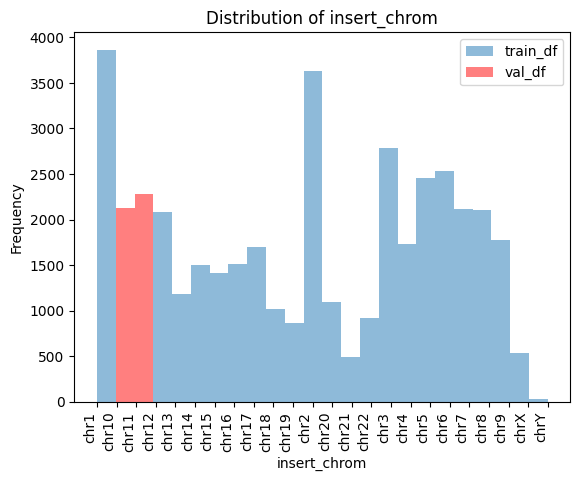

In [8]:
chrom_to_label = {chrom: i for i, chrom in enumerate(np.unique(np.concatenate([train_df['insert_chrom'], val_df['insert_chrom']])))}

train_df.loc[:, 'insert_chrom_label'] = train_df['insert_chrom'].map(chrom_to_label)
val_df.loc[:, 'insert_chrom_label'] = val_df['insert_chrom'].map(chrom_to_label)
bins = np.histogram_bin_edges(np.concatenate([train_df['insert_chrom_label'], val_df['insert_chrom_label']]), bins=24)

plt.hist(train_df['insert_chrom_label'], bins=bins, alpha=0.5, label='train_df')
plt.hist(val_df['insert_chrom_label'], bins=bins, alpha=0.5, color='red', label='val_df')
plt.xlabel('insert_chrom')
plt.ylabel('Frequency')
plt.title('Distribution of insert_chrom')
plt.xticks(ticks=range(len(chrom_to_label)), labels=chrom_to_label.keys(), rotation=90, ha='right')
plt.legend(loc='upper right')
plt.show()

<Axes: >

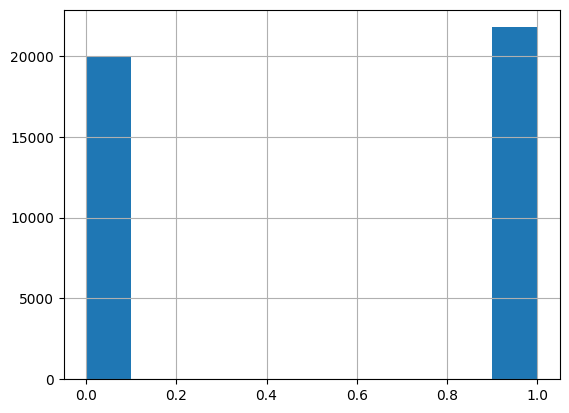

In [9]:
# Dataset are balnced
df['is_active'].hist()

<Axes: >

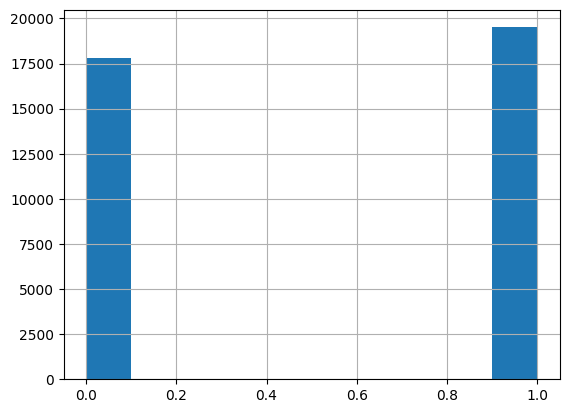

In [10]:
train_df['is_active'].hist()

<Axes: >

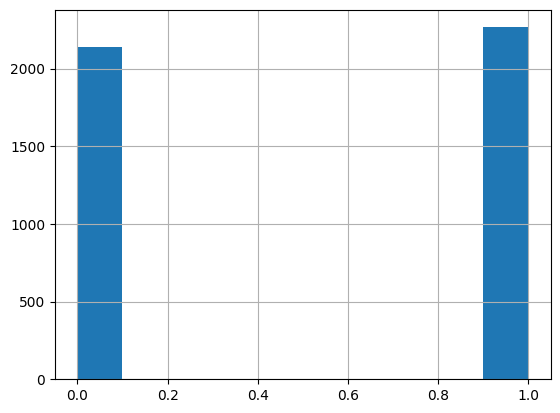

In [11]:
val_df['is_active'].hist()

<Axes: >

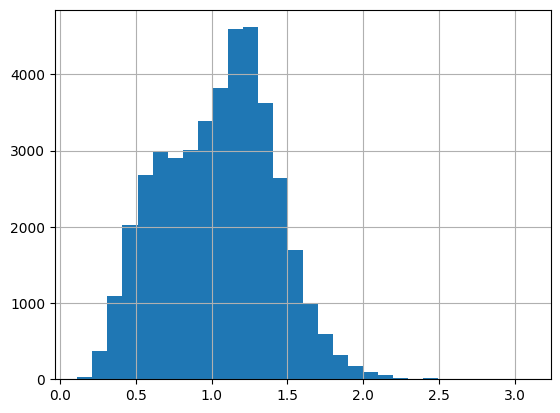

In [12]:
# Histogram of continous values
df['rna_dna_ratio'].hist(bins=30)

<Axes: >

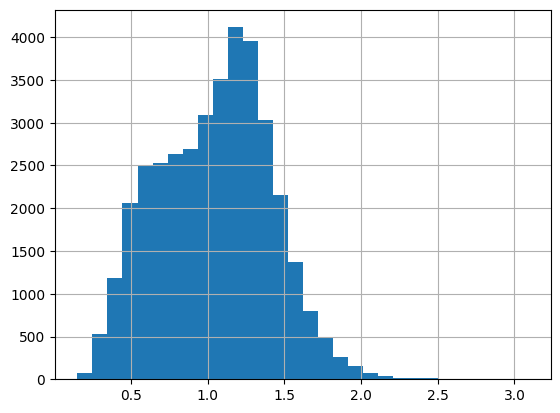

In [13]:
train_df['rna_dna_ratio'].hist(bins=30)

<Axes: >

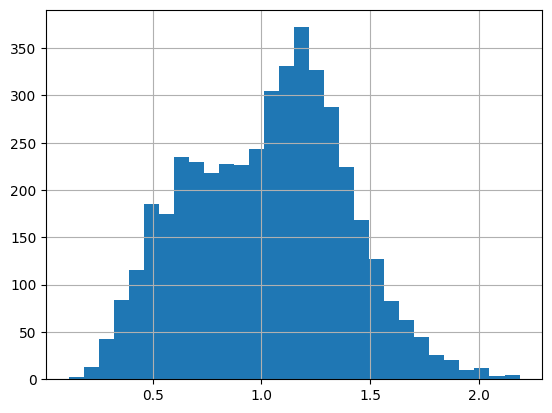

In [14]:
val_df['rna_dna_ratio'].hist(bins=30)

In [15]:
# Sanity check of sequence length
df['sequence_length'] = df['sequence'].apply(len)
print(df['sequence_length'].unique())

[271]


In [16]:
class OHEncoder:
    def __init__(self, categories=np.array(['A', 'C', 'G', 'T'])):
        self.encoder = Encoder(sparse_output=False, categories=[categories])
        self.dictionary = categories
        self.encoder.fit(categories.reshape(-1, 1))

    def __call__(self, seq, info=False):
        seq = list(seq)
        # Jeśli w sekwencji występuje znak 'N', w naszych danych nie ma, ale może być
        if 'N' in seq:
            pos = [i for i, el in enumerate(seq) if el == 'N']
            for p in pos:
                seq[p] = random.choice(self.dictionary)

        s = np.array(seq).reshape(-1, 1)
        encoded = self.encoder.transform(s).T  # wynik: macierz (4, seq_len)
        return torch.tensor(encoded).unsqueeze(0).unsqueeze(0).float()

In [17]:
class CustomCNNEncoder(nn.Module):
    def __init__(self, seq_len=271, num_channels=[100, 50, 50], kernel_widths=[9, 7, 3],
                 pooling_widths=[3, 4, 4], num_units=[2000, 64], dropout=0.75):
        """ Ta sieć przetwarza 2D one-hot zakodowaną sekwencję.
        Wynik (wektor cech) ma wymiar num_units[-1].
        """
        super(CustomCNNEncoder, self).__init__()
        paddings = [int((w - 1) / 2) for w in kernel_widths]
        self.seq_len = seq_len

        conv_modules = []
        # Wejście: jeden kanał (obraz o rozmiarze 1 x (4, seq_len))
        num_channels_in = [1] + num_channels
        for num, (in_chan, out_chan, kernel, padding, pool) in \
                enumerate(zip(num_channels_in[:-1], num_channels_in[1:], kernel_widths, paddings, pooling_widths)):
            k = 4 if num == 0 else 1
            conv_modules += [
                nn.Conv2d(in_chan, out_chan, kernel_size=(k, kernel), padding=(0, padding)),
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(1, pool), ceil_mode=True)
            ]
            seq_len = math.ceil(seq_len / pool)
        self.conv_layers = nn.Sequential(*conv_modules)
        self.conv_out_size = 1 * seq_len * num_channels_in[-1]

        # Wspólna głowica FC – ekstraktor cech
        fc_layers = []
        num_units_fc = [self.conv_out_size] + num_units
        for in_units, out_units in zip(num_units_fc[:-1], num_units_fc[1:]):
            fc_layers += [nn.Linear(in_units, out_units), nn.ReLU(), nn.Dropout(p=dropout)]
        self.fc_shared = nn.Sequential(*fc_layers)

    def forward(self, x):
        # x: tensor o kształcie (B, 1, 4, seq_len)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        feat = self.fc_shared(x)
        return feat  # [B, 64]

In [18]:
class NucleotideEmbedding(nn.Module):
    def __init__(self, model_name='InstaDeepAI/nucleotide-transformer-v2-100m-multi-species'):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.hidden_size = self.model.config.hidden_size

    def forward(self, seq_list):
        tokens = self.tokenizer(seq_list, return_tensors='pt', padding=True, truncation=True)
        tokens = {k: v.to(DEVICE) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = self.model(**tokens)

        # Check if hidden_states is present and not None
        if outputs.hidden_states is not None:
            embeddings = outputs.hidden_states[-1].mean(dim=1)
        else:
            embeddings = torch.zeros(len(seq_list), self.hidden_size, device=DEVICE)

        return embeddings

In [19]:
class CombinedModel(nn.Module):
    def __init__(self, seq_len: int):
        """ Model łączy dwa źródła cech:
         - Cecha z Nucleotide Transformer – wejście: surowa sekwencja jako str
         - Cecha z CustomCNNEncoder – wejście: tensor o kształcie (1, 4, seq_len)
        Następnie cechy są scalane i przekazywane:
         - Klasyfikacyjnej – is_active (binarna)
         - Regresyjnej – rna_dna_ratio (ciągła)
        """
        super(CombinedModel, self).__init__()
        self.nt_transformer = NucleotideEmbedding()  # TRANSFER LEARNIG DO POTENCJALNEJ ZMIANY
        # self.cnn_encoder = CustomCNNEncoder(seq_len=seq_len)  # one-hot encoder oparty na CNN
        self.cnn_encoder = SeqNN(
            seqsize=271,
            use_single_channel=True,
            block_sizes=[256, 128, 128, 64, 64, 64, 64],
            ks=7,
            resize_factor=4,
            se_reduction=4,
            final_ch=18,
            to_extract=[0],
            pool_dim=4,
            standalone=False
        ).to(DEVICE)
        self.cnn_encoder.load_state_dict(torch.load("/mnt/e/Pobrane/model_150.pth", map_location=DEVICE), strict=False)

        # Wymiar cech: nt_transformer.hidden_size + shape CNN (64)
        # fused_dim = self.nt_transformer.hidden_size + 64
        # self.classifier = nn.Linear((128+64)*4 + self.nt_transformer.hidden_size, 1)
        self.classifier = nn.Sequential(
            nn.Linear((sum([self.cnn_encoder.block_sizes[i+1] for i in self.cnn_encoder.to_extract])+self.cnn_encoder.block_sizes[-1])*self.cnn_encoder.pool_dim + self.nt_transformer.hidden_size, 512),
            nn.Dropout(0.3),
            nn.SiLU(),
            nn.Linear(512, 32),
            nn.SiLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        self.regressor = nn.Linear(self.cnn_encoder.seqsize*self.cnn_encoder.final_ch + self.nt_transformer.hidden_size, 1)

    def forward(self, raw_seq_list, oh_tensor):
        nt_features = self.nt_transformer(raw_seq_list)  # (B, hidden_size)
        cnn_features_reg, cnn_features_class = self.cnn_encoder(oh_tensor)

        # fused = torch.cat([nt_features, cnn_features], dim=1)
        out_cls = torch.sigmoid(self.classifier(torch.cat([nt_features, cnn_features_class], dim=1)))
        out_reg = self.regressor(torch.cat([nt_features, cnn_features_reg], dim=1))
        return out_cls, out_reg

In [20]:
class SequenceDataset(Dataset):
    def __init__(self, df, oh_encoder):
        """ df powinno zawierać kolumny:
          - sequence
          - rna_dna_ratio
          - is_active
        """
        self.df = df.reset_index(drop=True)
        self.oh_encoder = oh_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq = row['sequence']  # sekwencja jako str
        oh = self.oh_encoder(seq)  # tensor (1, 4, seq_len)
        if oh is None:
            return None
        label_cls = float(row['is_active'])
        label_reg = float(row['rna_dna_ratio'])
        return seq, oh, torch.tensor(label_cls, dtype=torch.float32), torch.tensor(label_reg, dtype=torch.float32)

def collate_fn(batch):
    # Usuwamy próbki None
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    raw_seqs, oh_list, y_cls, y_reg = zip(*batch)
    oh_tensor = torch.cat(oh_list, dim=0)  # kształt: (B, 1, 4, seq_len)
    y_cls = torch.stack(y_cls)
    y_reg = torch.stack(y_reg)
    return list(raw_seqs), oh_tensor, y_cls, y_reg

In [21]:
oh_encoder = OHEncoder()
train_dataset = SequenceDataset(train_df, oh_encoder)
val_dataset = SequenceDataset(val_df, oh_encoder)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
# model = CombinedModel(seq_len=271).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion_cls = nn.BCELoss()
# criterion_reg = nn.MSELoss()
# scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)


# train_losses = []
# val_losses = []

2025-04-16 21:52:01.933302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744836721.947688    3298 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744836721.951871    3298 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 21:52:01.966283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_3298/850706063.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default

In [44]:
model = SeqNN(
    seqsize=271,
    use_single_channel=True,
    block_sizes= [256, 128, 128, 64, 64, 64, 64],
    ks=7,
    resize_factor=4,
    se_reduction=4,
    final_ch=18,
    to_extract = [0],
    pool_dim=3,
    standalone=True
).to(DEVICE)
model.load_state_dict(torch.load("/mnt/e/Pobrane/model_150.pth", map_location=DEVICE), strict=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1)
criterion_cls = nn.BCELoss()
criterion_reg = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.3,
    patience = 1,
)


train_losses = []
val_losses = []

/tmp/ipykernel_3298/1512007163.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mnt/e/Pobrane/model_150.pth", map_location=DEVICE), st

In [24]:
print(model)

CombinedModel(
  (nt_transformer): NucleotideEmbedding(
    (model): EsmForMaskedLM(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(4107, 512, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(2050, 512, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-21): 22 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(in_features=512, out_features=512, bias=True)
                  (key): Linear(in_features=512, out_features=512, bias=True)
                  (value): Linear(in_features=512, out_features=512, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                  (rotary_embeddings): RotaryEmbedding()
                )
                (output): EsmSelfOutput(
                  (dense): Linear(in_features=512, out_features=512

In [28]:
batch = next(iter(train_loader))
x = batch[1].squeeze(1)
x = torch.cat([x, torch.zeros((x.shape[0], 2, x.shape[2]), device=x.device)], dim=1).to(DEVICE)
print(x.shape)
y = model(x)
print(y[0][0], y[1][0])
print(batch[2], batch[3])

torch.Size([32, 6, 271])
tensor([0.4746], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2312], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.]) tensor([1.3339, 1.2826, 1.1143, 0.7430, 0.6388, 0.9193, 1.7220, 0.4189, 1.1580,
        1.3901, 1.5619, 0.4849, 0.5997, 0.7369, 0.6722, 0.3476, 1.2230, 1.4729,
        0.7332, 0.9612, 0.8271, 1.5395, 0.8880, 0.4216, 0.6164, 1.6678, 0.8042,
        1.4735, 1.5541, 1.5244, 1.1676, 0.4090])


In [ ]:
train_df.describe()

,rna_dna_ratio,is_active,insert_chrom_label
count,37326.000000,37326.000000,37326.000000
mean,1.042660,0.522692,11.519665
std,0.367381,0.499492,6.638904
min,0.149372,0.000000,0.000000
25%,0.753619,0.000000,6.000000
50%,1.071731,1.000000,11.000000
75%,1.301316,1.000000,17.000000
max,3.090281,1.000000,23.000000


In [ ]:
# torch.cuda.empty_cache()

In [45]:
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        if batch is None:
            continue
        raw_seqs, oh_tensor, y_cls, y_reg = batch
        oh_tensor, y_cls, y_reg = oh_tensor.to(DEVICE), y_cls.to(DEVICE), y_reg.to(DEVICE)

        optimizer.zero_grad()
        x = torch.cat([oh_tensor.squeeze(1), torch.zeros((oh_tensor.shape[0], 2, oh_tensor.shape[-1]), device=DEVICE)], dim=1)
        out_cls, out_reg = model(x)
        loss_reg = criterion_reg(out_reg.squeeze(-1), y_reg)
        loss_cls = criterion_cls(out_cls.squeeze(-1), y_cls)
        loss = loss_cls + loss_reg
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        pbar.set_postfix(loss_reg=loss_reg.item(), loss_cls=loss_cls.item(), loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Walidacja
    model.eval()
    epoch_val_loss = 0
    avg_reg = 0
    avg_cls = 0
    f1 = 0
    precision = 0
    recall = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue
            raw_seqs, oh_tensor, y_cls, y_reg = batch
            oh_tensor, y_cls, y_reg = oh_tensor.to(DEVICE), y_cls.to(DEVICE), y_reg.to(DEVICE)
            x = torch.cat([oh_tensor.squeeze(1), torch.zeros((oh_tensor.shape[0], 2, oh_tensor.shape[-1]), device=DEVICE)], dim=1)
            out_cls, out_reg = model(x)
            loss_reg = criterion_reg(out_reg.squeeze(-1), y_reg)
            avg_reg += loss_reg
            loss_cls = criterion_cls(out_cls.squeeze(-1), y_cls)
            avg_cls += loss_cls
            loss_val = loss_cls + loss_reg
            epoch_val_loss += loss_val.item()
            f1 += f1_score(y_cls.cpu().numpy(), (out_cls.squeeze(-1).cpu().numpy() > 0.5).astype(int))
            precision += precision_score(y_cls.cpu().numpy(), (out_cls.squeeze(-1).cpu().numpy() > 0.5).astype(int))
            recall += recall_score(y_cls.cpu().numpy(), (out_cls.squeeze(-1).cpu().numpy() > 0.5).astype(int))
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_reg /= len(val_loader)
    avg_cls /= len(val_loader)
    f1 /= len(val_loader)
    precision /= len(val_loader)
    recall /= len(val_loader)
    val_losses.append(avg_val_loss)
    

    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Reg Loss = {avg_reg:.4f}, Cls Loss = {avg_cls:.4f}, F1 = {f1:.4f}, Precision = {precision}, Recall = {recall}")

Epoch 1:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7856, Val Loss = 0.7225, Reg Loss = 0.1050, Cls Loss = 0.6175, F1 = 0.6509, Precision = 0.6972574013309643, Recall = 0.6213189268193305


Epoch 2:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.6669, Val Loss = 0.6410, Reg Loss = 0.0884, Cls Loss = 0.5526, F1 = 0.7397, Precision = 0.6884196023354553, Recall = 0.8094972371321811


Epoch 3:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.6250, Val Loss = 0.6242, Reg Loss = 0.0849, Cls Loss = 0.5393, F1 = 0.7502, Precision = 0.6946618143251201, Recall = 0.8261887509186941


Epoch 4:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.6053, Val Loss = 0.6161, Reg Loss = 0.0842, Cls Loss = 0.5319, F1 = 0.7596, Precision = 0.6913065679730304, Recall = 0.8540036682493605


Epoch 5:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.5885, Val Loss = 0.6271, Reg Loss = 0.0848, Cls Loss = 0.5422, F1 = 0.7574, Precision = 0.6713293446248125, Recall = 0.8806153084176704


Epoch 6:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.5754, Val Loss = 0.6052, Reg Loss = 0.0865, Cls Loss = 0.5187, F1 = 0.7614, Precision = 0.7027694876460339, Recall = 0.8438561758246435


Epoch 7:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.5592, Val Loss = 0.6647, Reg Loss = 0.0973, Cls Loss = 0.5674, F1 = 0.7561, Precision = 0.6546386430588963, Recall = 0.9095295031852774


Epoch 8:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.5469, Val Loss = 0.6153, Reg Loss = 0.0833, Cls Loss = 0.5321, F1 = 0.6954, Precision = 0.8096335454938561, Recall = 0.6193465180492368


Epoch 9:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.5126, Val Loss = 0.5610, Reg Loss = 0.0740, Cls Loss = 0.4870, F1 = 0.7743, Precision = 0.7382394128178863, Recall = 0.8244851543091541


Epoch 10:   0%|          | 0/1167 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.5033, Val Loss = 0.5597, Reg Loss = 0.0725, Cls Loss = 0.4872, F1 = 0.7690, Precision = 0.7564343010505079, Recall = 0.7914960433729779


Epoch 11:   0%|          | 0/1167 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

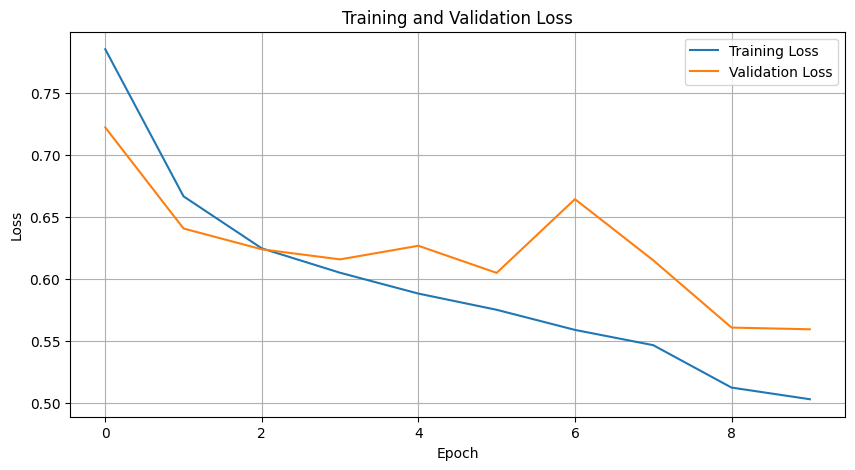

In [46]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
def evaluate(model, loader):
    model.eval()
    y_true_cls, y_pred_cls = [], []
    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue
            raw_seqs, oh_tensor, y_cls, _ = batch
            oh_tensor = oh_tensor.to(DEVICE)
            x = torch.cat([oh_tensor.squeeze(1), torch.zeros((oh_tensor.shape[0], 2, oh_tensor.shape[-1]), device=DEVICE)], dim=1)
            out_cls, out_reg = model(x)
            preds = (out_cls.squeeze().cpu().numpy() > 0.5).astype(int)

            y_pred_cls.extend(preds.tolist())
            y_true_cls.extend(y_cls.numpy().tolist())

    # Calculate F1 score
    f1 = f1_score(y_true_cls, y_pred_cls)
    return f1

val_f1 = evaluate(model, val_loader)
print(f"Validation F1 Score: {val_f1:.3f}")

Validation F1 Score: 0.781
